In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch


In [23]:
import pickle
with open('diploma/dicts/dct_isoclines_none_hid=32_out=32_enc=32.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [60]:
!stat 'diploma/dicts/dct_isoclines_none_hid=32_out=32_enc=32.pkl'

  File: diploma/dicts/dct_isoclines_none_hid=32_out=32_enc=32.pkl
  Size: 62066     	Blocks: 128        IO Block: 4096   regular file
Device: 802h/2050d	Inode: 839472      Links: 1
Access: (0664/-rw-rw-r--)  Uid: ( 1017/v_shaposhnikov)   Gid: ( 1021/v_shaposhnikov)
Access: 2023-05-18 15:21:53.690026789 +0300
Modify: 2023-05-18 07:56:34.811643952 +0300
Change: 2023-05-18 07:56:34.811643952 +0300
 Birth: -


In [24]:
loaded_dict

{(144, 80): 1.8179049491882324,
 (144, 96): 1.7756677865982056,
 (144, 143): 1.7748093605041504,
 (208, 128): 1.7443692684173584,
 (208, 207): 1.736041784286499,
 (128, 127): 1.721795678138733,
 (128, 80): 1.6797635555267334,
 (176, 175): 1.6635873317718506,
 (208, 112): 1.6504313945770264,
 (112, 111): 1.6424809694290161,
 (144, 112): 1.6299699544906616,
 (96, 95): 1.6277672052383423,
 (208, 144): 1.6234755516052246,
 (192, 191): 1.6188827753067017,
 (208, 96): 1.613377332687378,
 (224, 223): 1.595848798751831,
 (208, 80): 1.5823256969451904,
 (128, 96): 1.5753624439239502,
 (160, 159): 1.5685994625091553,
 (80, 79): 1.561238169670105,
 (32, 32): 1.5256403684616089,
 (224, 160): 1.5216244459152222,
 (32, 16): 1.5146580934524536,
 (64, 48): 1.5066769123077393,
 (64, 64): 1.4958323240280151,
 (240, 239): 1.4943015575408936,
 (32, 31): 1.494205355644226,
 (64, 32): 1.4896752834320068,
 (32, 0): 1.4879522323608398,
 (16, 16): 1.487747073173523,
 (16, 0): 1.4873181581497192,
 (208, 160): 1

In [30]:
def create_perc_split(img, amount_of_steps, st = 0):
    previous = np.percentile(img, 100)
    draw_img = np.zeros_like(img)
    step = 100 / amount_of_steps
    for itt_num in range(0, amount_of_steps):
        border = np.percentile(img, 100 - step * (itt_num + 1))
        result = np.where((previous >= img) & (img > border), itt_num + st, 0)
        previous = border
        draw_img += result
    return draw_img

def prepare_data(img, mask, amount_of_steps):
    h, w = img.shape
    results = []
    pixel_per_isocline = h * w // amount_of_steps
    
    for i in range(amount_of_steps):
        line = img[mask == i]
        if line.shape[0] != pixel_per_isocline:
            idx_list = [np.random.randint(0, line.shape[0]) for _ in range(abs(pixel_per_isocline - line.shape[0]))]
            is_insert = True if line.shape[0] < pixel_per_isocline else False
            
            if not is_insert:
                line = np.delete(line, idx_list)
            else:
                mean_val = line.mean()
                line = np.insert(line, idx_list, mean_val)
        results.append(line)
    return results

# Get fourier batches 
def split_tensor(imgs, split_coefs=None):
    if split_coefs is None:
        split_coefs = [1, 2, 4]
    result = []

    *_, h, w = imgs.shape
    last_val = 0
    image_list, specter_list, mask_list = [], [], []
    

    for coef in split_coefs:
        image = np.zeros((h, w))
        specter = np.zeros((h, w))
        res_mask = np.zeros((h, w))
        step = h // coef
        # add fft
        row_data = []
        for y in range(0, w, step):
            step_result = []
            for x in range(0, h, step):
                #temperory unused
#                 value = torch.log(1 + torch.abs(torch.fft.fftshift(torch.fft.fft2(imgs[..., x:x + step, y:y + step]))))
                value = torch.abs(torch.fft.fftshift(torch.fft.fft2(imgs[..., x:x + step, y:y + step])))
                image[x:x+step, y:y+step] = imgs[..., x:x + step, y:y + step]
#                 res_mask[x:x+step, y:y+step] = create_perc_split(value, amount_of_steps=16, st=last_val)
                res_mask[x:x+step, y:y+step] = create_perc_split(value, amount_of_steps=16, st=0)

                specter[x:x+step, y:y+step] = torch.log(1 + torch.abs(torch.fft.fftshift(torch.fft.fft2(imgs[..., x:x + step, y:y + step]))))
                value -= value.min()
                value /= value.max()
                mask = create_perc_split(value, amount_of_steps=16)
                data = prepare_data(value, mask, amount_of_steps=16)
                last_val += 16
                
                result.append(data)
#             row_data.append(np.concatenate(step_result, axis=0))
#         result.append(np.concatenate(row_data, axis=1))
        image_list.append(image)
        specter_list.append(specter)
        mask_list.append(res_mask)

    return result, image_list, specter_list, mask_list


In [ ]:
from collections import defaultdict

data = defaultdict(int)
for (x1, x2), _ in sorted(loaded_dict.items(), key=lambda item: item[1], reverse=True)[:1000]:
    data[x1] += 1
    data[x2] += 1

In [45]:
sorted(data.items(), key=lambda item: item[1], reverse=True)


[(324, 18),
 (325, 18),
 (326, 18),
 (327, 18),
 (328, 18),
 (329, 18),
 (323, 18),
 (330, 18),
 (331, 18),
 (332, 18),
 (333, 18),
 (334, 17),
 (80, 15),
 (96, 15),
 (112, 15),
 (304, 15),
 (320, 15),
 (17, 14),
 (1, 14),
 (193, 14),
 (144, 13),
 (208, 13),
 (128, 13),
 (176, 13),
 (224, 13),
 (49, 13),
 (33, 13),
 (34, 13),
 (194, 13),
 (82, 13),
 (45, 13),
 (78, 13),
 (44, 13),
 (43, 13),
 (42, 13),
 (75, 12),
 (77, 12),
 (76, 12),
 (46, 12),
 (192, 11),
 (97, 11),
 (18, 11),
 (2, 11),
 (129, 11),
 (98, 11),
 (114, 11),
 (130, 11),
 (3, 11),
 (243, 11),
 (72, 11),
 (73, 11),
 (74, 11),
 (41, 11),
 (39, 11),
 (4, 11),
 (40, 11),
 (160, 10),
 (145, 10),
 (146, 10),
 (50, 10),
 (81, 10),
 (303, 10),
 (113, 10),
 (51, 10),
 (177, 10),
 (178, 10),
 (19, 10),
 (195, 10),
 (71, 10),
 (242, 10),
 (66, 9),
 (147, 9),
 (162, 9),
 (244, 9),
 (20, 9),
 (38, 9),
 (65, 8),
 (35, 8),
 (52, 8),
 (67, 8),
 (115, 8),
 (99, 8),
 (131, 8),
 (70, 8),
 (290, 8),
 (276, 8),
 (196, 8),
 (26, 8),
 (29, 8),


In [46]:
sorted(data.items(), key=lambda item: item[1], reverse=True)
nodes_ids = set()
for x, y in data.items():
    if y > 7:
        nodes_ids.add(x)

In [47]:
len(nodes_ids)

95

In [48]:
# nodes_ids_cats = nodes_ids

In [17]:
!ls /raid/data/chest_xray/train/PNEUMONIA

person1000_bacteria_2931.jpeg  person352_bacteria_1625.jpeg
person1000_virus_1681.jpeg     person353_bacteria_1626.jpeg
person1001_bacteria_2932.jpeg  person353_bacteria_1628.jpeg
person1002_bacteria_2933.jpeg  person353_virus_728.jpeg
person1003_bacteria_2934.jpeg  person354_bacteria_1632.jpeg
person1003_virus_1685.jpeg     person354_bacteria_1633.jpeg
person1004_bacteria_2935.jpeg  person354_bacteria_1634.jpeg
person1004_virus_1686.jpeg     person354_bacteria_1635.jpeg
person1005_bacteria_2936.jpeg  person354_virus_729.jpeg
person1005_virus_1688.jpeg     person355_bacteria_1637.jpeg
person1006_bacteria_2937.jpeg  person355_virus_730.jpeg
person1007_bacteria_2938.jpeg  person355_virus_731.jpeg
person1007_virus_1690.jpeg     person356_bacteria_1638.jpeg
person1008_bacteria_2939.jpeg  person356_virus_733.jpeg
person1008_virus_1691.jpeg     person357_bacteria_1639.jpeg
person1009_virus_1694.jpeg     person357_bacteria_1640.jpeg
person100_virus_184.jpeg       person357_virus_734.jpeg
pers

In [49]:
!ls /raid/data/chest_xray/train/NORMAL/IM-0117-0001.jpeg

/raid/data/chest_xray/train/NORMAL/IM-0117-0001.jpeg


In [20]:
img = Image.open('/raid/data/chest_xray/train/NORMAL/IM-0117-0001.jpeg')


In [80]:
img = Image.open('/raid/data/cats_dogs_dataset/PetImages/Cat/8.jpg')
# img = Image.open('/raid/data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')

img_gray = img.convert('L').resize((224, 224), Image.ANTIALIAS)
result, image_list, specter_list, mask_list = split_tensor(torch.tensor(np.array(img_gray)))


/tmp/ipykernel_19407/3471217046.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_gray = img.convert('L').resize((224, 224), Image.ANTIALIAS)


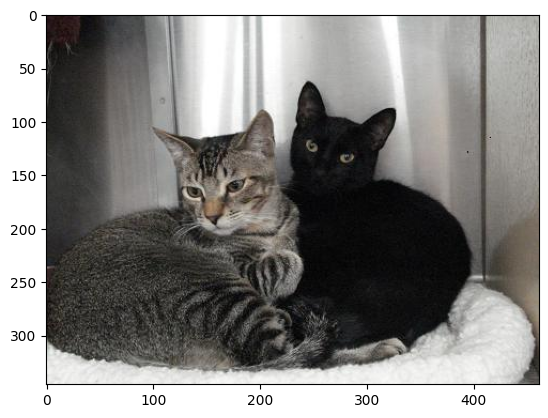

In [81]:
plt.imshow(img, cmap='gray')

In [28]:
mask_list

[array([[15., 14., 13., ..., 15., 13., 14.],
        [15., 15., 15., ..., 13., 15., 15.],
        [15., 15., 15., ..., 15., 15., 15.],
        ...,
        [14., 15., 15., ..., 14., 14., 15.],
        [15., 15., 15., ..., 15., 15., 15.],
        [15., 15., 15., ..., 15., 15., 15.]]),
 array([[31., 29., 30., ..., 62., 63., 63.],
        [31., 31., 30., ..., 62., 63., 63.],
        [31., 30., 30., ..., 63., 63., 62.],
        ...,
        [47., 47., 46., ..., 79., 79., 79.],
        [47., 47., 46., ..., 78., 78., 79.],
        [47., 47., 47., ..., 79., 79., 79.]]),
 array([[ 95.,  94.,   0., ..., 284., 284., 283.],
        [ 92.,  94.,  93., ..., 286., 287., 285.],
        [ 93.,  95.,  94., ..., 286., 286., 282.],
        ...,
        [142., 141., 141., ..., 334., 334., 335.],
        [141., 142., 143., ..., 334., 335., 335.],
        [142., 142., 141., ..., 333., 335., 332.]])]

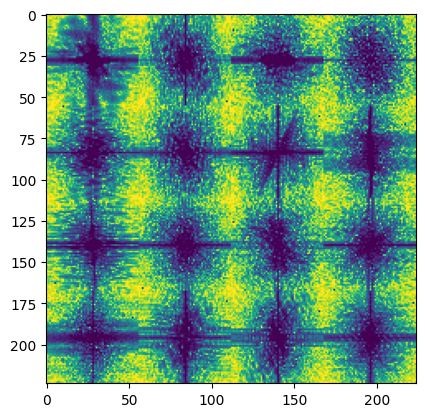

In [39]:
plt.imshow(mask_list[2])

In [77]:
from collections import defaultdict

nodes = defaultdict(int)
for (x1, x2), _ in sorted(loaded_dict.items(), key=lambda item: item[1], reverse=True)[:1000]:
    nodes[x1] += 1
    nodes[x2] += 1

nodes_ids = set()
for x, y in nodes.items():
    if y > 8:
        nodes_ids.add(x)

In [78]:
len(nodes_ids)

76

In [79]:
nodes_ids

{1,
 2,
 3,
 4,
 17,
 18,
 19,
 20,
 33,
 34,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 49,
 50,
 51,
 66,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 96,
 97,
 98,
 112,
 113,
 114,
 128,
 129,
 130,
 144,
 145,
 146,
 147,
 160,
 162,
 176,
 177,
 178,
 192,
 193,
 194,
 195,
 208,
 224,
 242,
 243,
 244,
 303,
 304,
 320,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334}

In [37]:
data

[array([[15., 14., 13., ..., 15., 13., 14.],
        [15., 15., 15., ..., 13., 15., 15.],
        [15., 15., 15., ..., 15., 15., 15.],
        ...,
        [14., 15., 15., ..., 14., 14., 15.],
        [15., 15., 15., ..., 15., 15., 15.],
        [15., 15., 15., ..., 15., 15., 15.]]),
 array([[15., 13., 14., ..., 14., 15., 15.],
        [15., 15., 14., ..., 14., 15., 15.],
        [15., 14., 14., ..., 15., 15., 14.],
        ...,
        [15., 15., 14., ..., 15., 15., 15.],
        [15., 15., 14., ..., 14., 14., 15.],
        [15., 15., 15., ..., 15., 15., 15.]]),
 array([[15., 14.,  0., ..., 12., 12., 11.],
        [12., 14., 13., ..., 14., 15., 13.],
        [13., 15., 14., ..., 14., 14., 10.],
        ...,
        [14., 13., 13., ..., 14., 14., 15.],
        [13., 14., 15., ..., 14., 15., 15.],
        [14., 14., 13., ..., 13., 15., 12.]])]

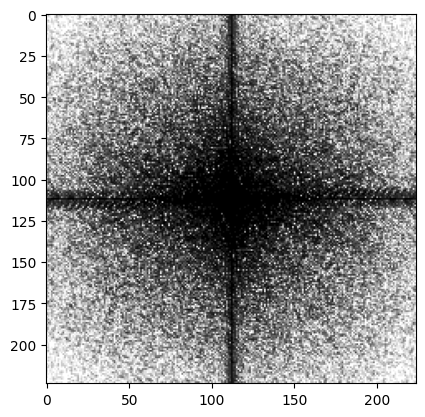

In [110]:
plt.imshow(mask_list[0], cmap='gray')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


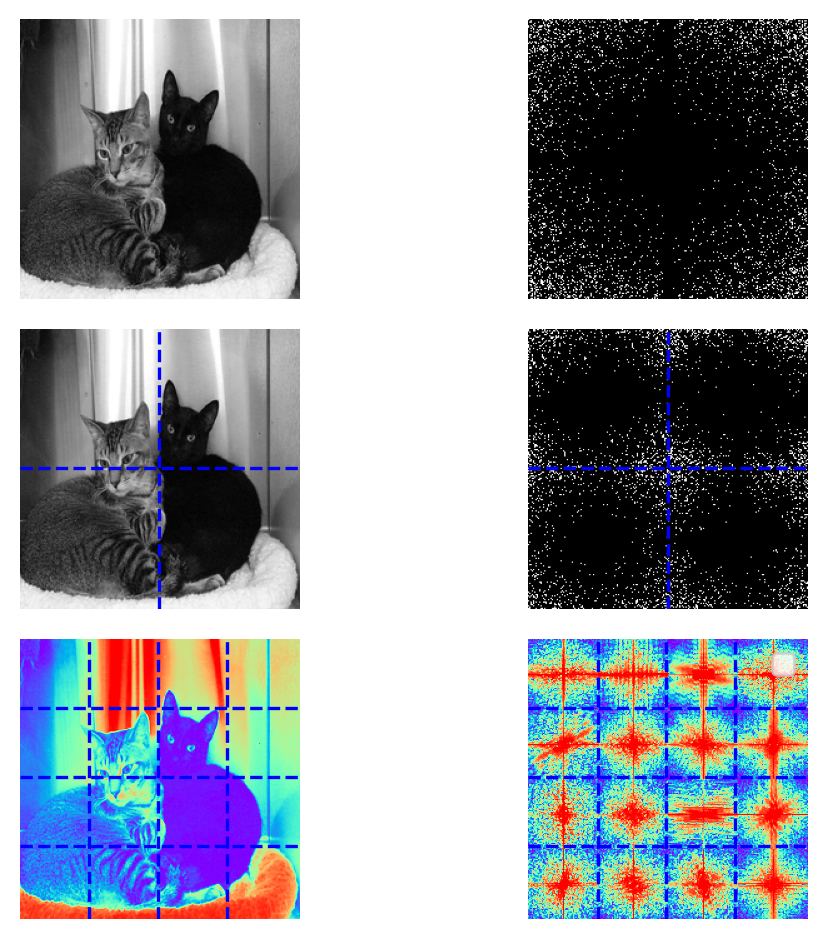

In [109]:
fig, ax = plt.subplots(3, 2, dpi=200)
for i, data in enumerate([image_list, mask_list]):
    res = data[0] if i == 0 else abs(data[0] - 15) == 1
    ax[0][i].imshow(res, cmap='gray' if i == 0 else 'gray')
    ax[0][i].axis('off')
    
    p = 2    
    res = data[1] if i == 0 else abs(data[1] - 15) == 1

    ax[1][i].imshow(res, cmap='gray' if i == 0 else 'gray')
#     ax[i][2].imshow(np.isin(data[2], list(nodes_ids)))
    
    for j in range(1, p):
        ax[1][i].axvline(223.5//p * j, color='blue', ls='--', linewidth=1.2)
        ax[1][i].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[1][i].axis('off')

    ax[2][i].imshow(abs(data[2] - 15), cmap='rainbow')
    p = 4
    for j in range(1, p):
        ax[2][i].axvline(223.5//p * j,color='blue',ls='--', linewidth=1.2)
        ax[2][i].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[2][i].axis('off')
ax[0][0].set_ylabel('SSS')

fig.tight_layout()
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


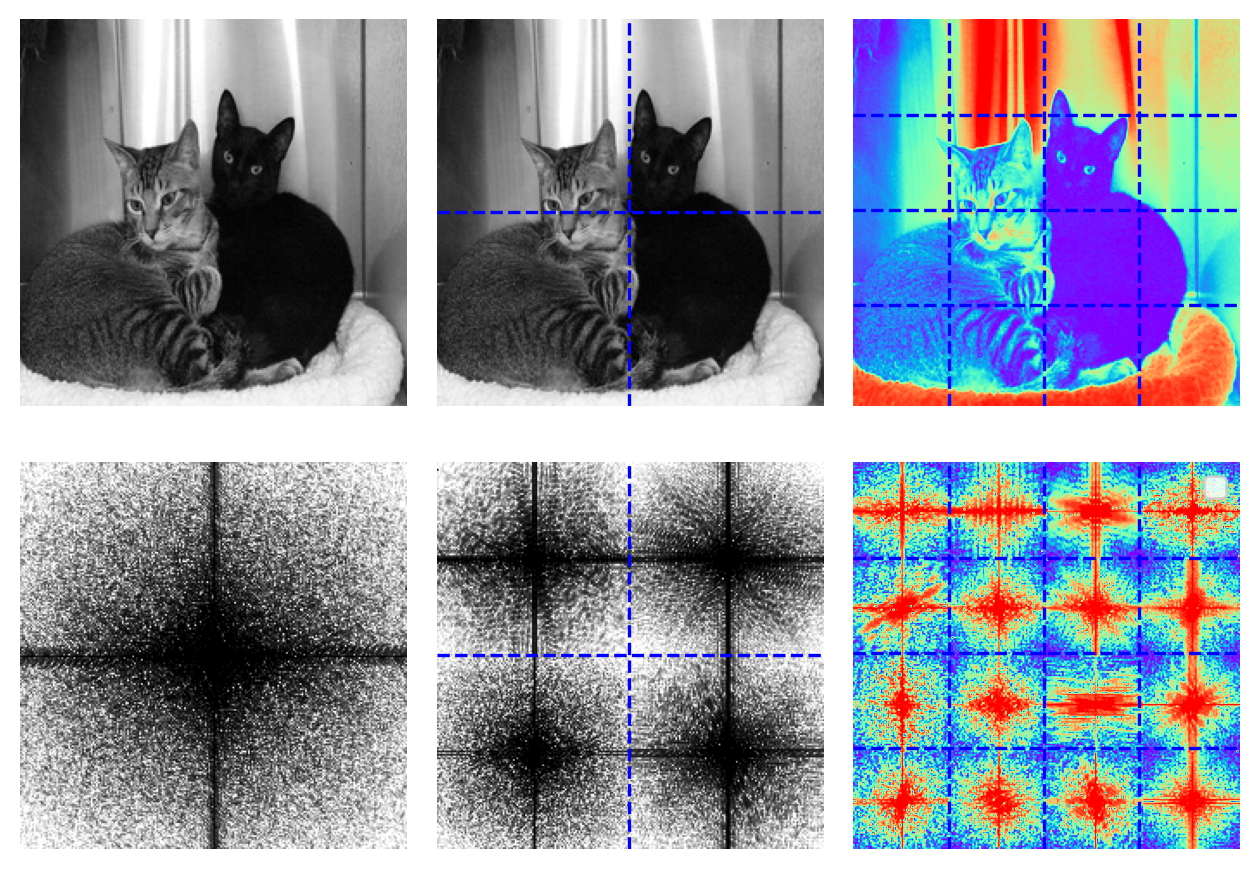

In [87]:
fig, ax = plt.subplots(2, 3, dpi=200)
for i, data in enumerate([image_list, mask_list]):
    ax[i][0].imshow(abs(data[0] - 0), cmap='gray')
    ax[i][0].axis('off')
    
    p = 2    
    ax[i][1].imshow(abs(data[1] - 0), cmap='gray')
#     ax[i][2].imshow(np.isin(data[2], list(nodes_ids)))
    
    for j in range(1, p):
        ax[i][1].axvline(223.5//p * j, color='blue', ls='--', linewidth=1.2)
        ax[i][1].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][1].axis('off')

    ax[i][2].imshow(abs(data[2] - 15), cmap='rainbow')
    p = 4
    for j in range(1, p):
        ax[i][2].axvline(223.5//p * j,color='blue',ls='--', linewidth=1.2)
        ax[i][2].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][2].axis('off')
ax[0][0].set_ylabel('SSS')

fig.tight_layout()
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


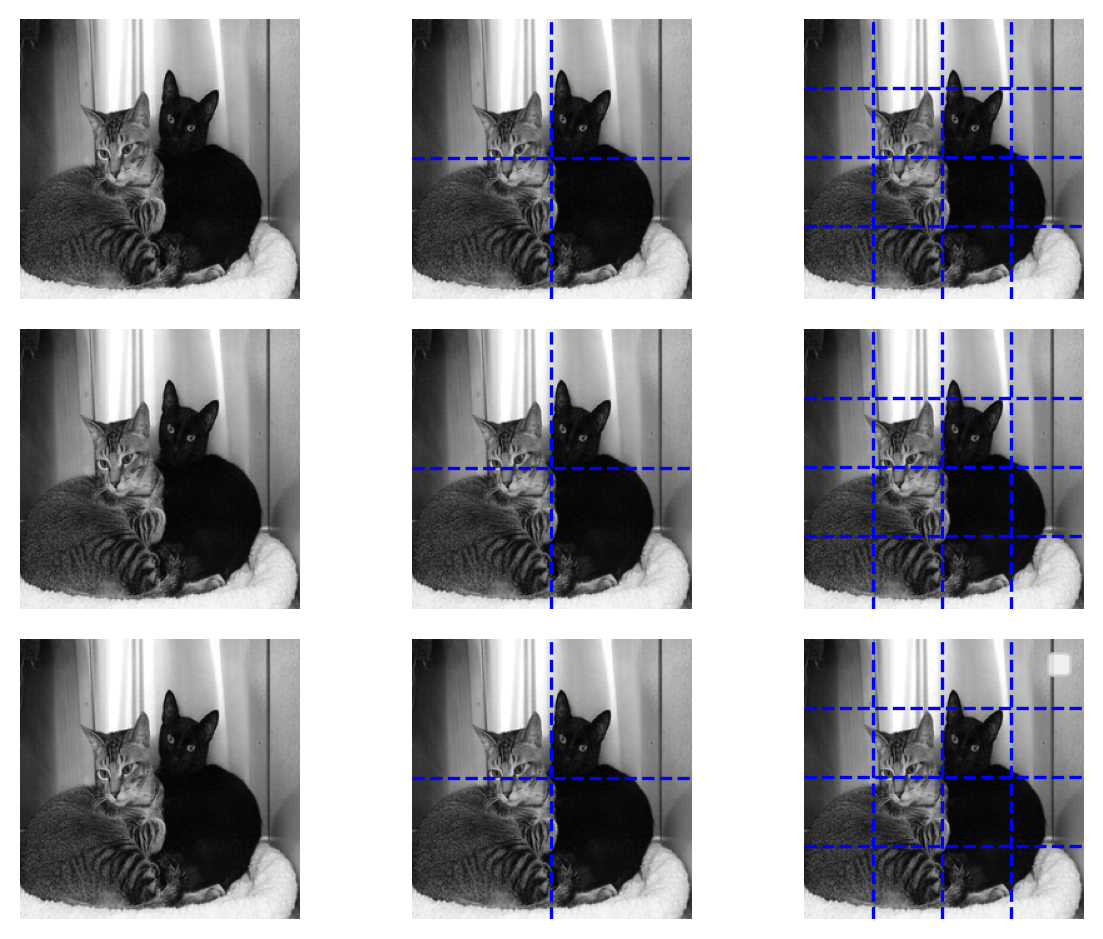

In [82]:
fig, ax = plt.subplots(3, 3, dpi=200)
for i, data in enumerate([image_list, image_list, image_list]):
    ax[i][0].imshow(data[0], cmap='gray')
    ax[i][0].axis('off')
    
    p = 2    
    ax[i][1].imshow(data[1], cmap='gray')
#     ax[i][2].imshow(np.isin(data[2], list(nodes_ids)))
    
    for j in range(1, p):
        ax[i][1].axvline(223.5//p * j, color='blue', ls='--', linewidth=1.2)
        ax[i][1].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][1].axis('off')

    ax[i][2].imshow(data[2], cmap='gray')
    p = 4
    for j in range(1, p):
        ax[i][2].axvline(223.5//p * j,color='blue',ls='--', linewidth=1.2)
        ax[i][2].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][2].axis('off')
ax[0][0].set_ylabel('SSS')

fig.tight_layout()
plt.legend()


NameError: name 'nodes_ids' is not defined

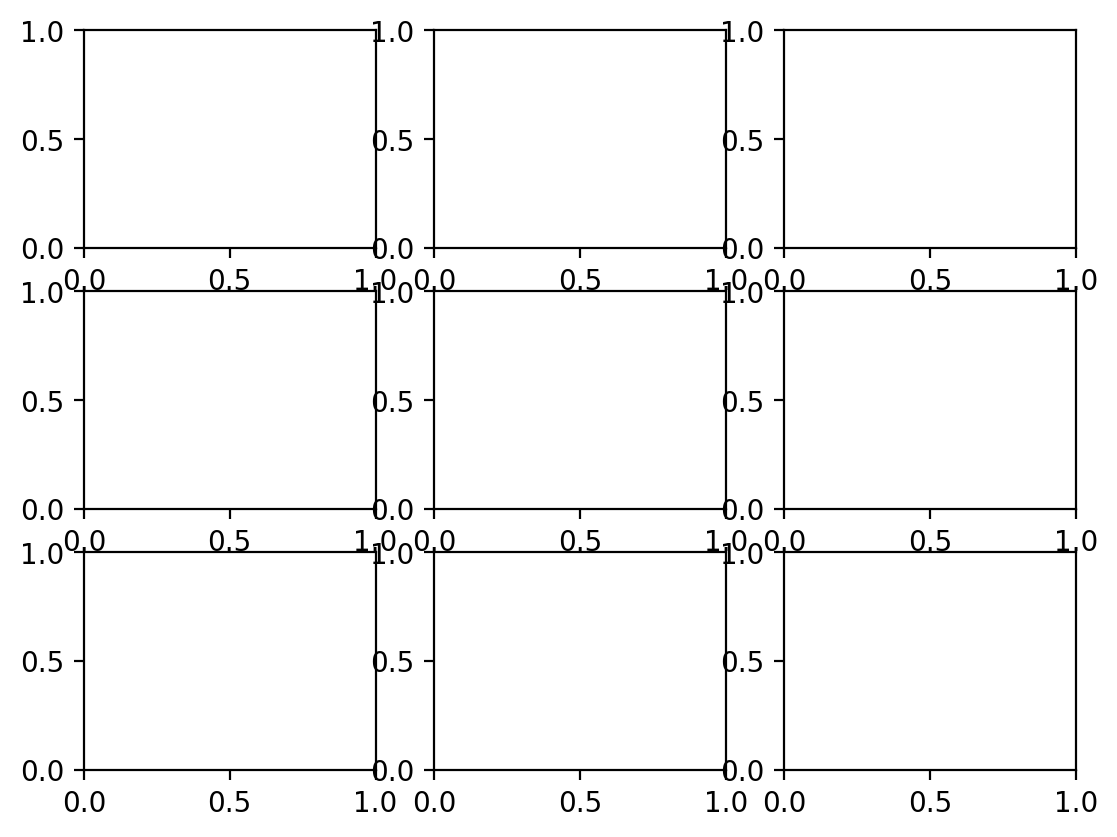

In [83]:
fig, ax = plt.subplots(3, 3, dpi=200)
for i, data in enumerate([image_list, [np.isin(mask, list(nodes_ids)) for mask in mask_list], [np.isin(mask, list(nodes_ids-nodes_ids_cats)) for mask in mask_list]]):
    ax[i][0].imshow(data[0], cmap='gray')
    ax[i][0].axis('off')
    
    p = 2    
    ax[i][1].imshow(data[1], cmap='gray')
#     ax[i][2].imshow(np.isin(data[2], list(nodes_ids)))
    
    for j in range(1, p):
        ax[i][1].axvline(223.5//p * j, color='blue', ls='--', linewidth=1.2)
        ax[i][1].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][1].axis('off')

    ax[i][2].imshow(data[2], cmap='gray')
    p = 4
    for j in range(1, p):
        ax[i][2].axvline(223.5//p * j,color='blue',ls='--', linewidth=1.2)
        ax[i][2].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][2].axis('off')
ax[0][0].set_ylabel('SSS')

fig.tight_layout()
plt.legend()


In [63]:
nodes_ids - nodes_ids_cats

{40,
 41,
 42,
 43,
 44,
 45,
 46,
 49,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 81,
 97,
 112,
 113,
 114,
 128,
 129,
 144,
 162,
 177,
 192,
 193,
 194,
 208,
 224,
 242,
 243,
 244,
 303,
 304,
 320,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333}

In [36]:
!ls /raid/data/cats_dogs_dataset/PetImages/Cat/1000.jpg

/raid/data/cats_dogs_dataset/PetImages/Cat/1000.jpg


In [46]:
img = Image.open('/raid/data/cats_dogs_dataset/PetImages/Cat/1000.jpg')
img_gray = img.convert('L').resize((224, 224), Image.ANTIALIAS)
result, image_list, specter_list, mask_list = split_tensor(torch.tensor(np.array(img_gray)))


/tmp/ipykernel_22403/655285812.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_gray = img.convert('L').resize((224, 224), Image.ANTIALIAS)


NameError: name 'counter' is not defined

224

In [1]:
fig, ax = plt.subplots(2, 3, dpi=200)

for i, data in enumerate([image_list, specter_list]):
    ax[i][0].imshow(data[0], cmap='gray')
    ax[i][0].axis('off')
    
    p = 2    
    ax[i][1].imshow(data[1], cmap='gray')
    for j in range(1, p):
        ax[i][1].axvline(223.5//p * j, color='blue', ls='--', linewidth=1.2)
        ax[i][1].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][1].axis('off')

    ax[i][2].imshow(data[2], cmap='gray')
    p = 4
    for j in range(1, p):
        ax[i][2].axvline(223.5//p * j,color='blue',ls='--', linewidth=1.2)
        ax[i][2].axhline(223.5//p * j,color='blue',ls='--', linewidth=1.2)

    ax[i][2].axis('off')
fig.tight_layout()


NameError: name 'plt' is not defined

In [15]:
len(result)

3136